<a href="https://colab.research.google.com/github/prernac-dotcom/generative_AI/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Reshape,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [49]:
(X_train,_),(_,_)=tf.keras.datasets.mnist.load_data()
X_train=(X_train.astype(np.float32)-127.5)/127.5
X_train = np.expand_dims(X_train, axis=-1)


In [50]:
buffer_size=60000
batch_size=128
dataset=tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(btach_size)

In [51]:
def build_generator():
  model = Sequential([
   Dense(256,input_shape=(100,)),
   LeakyReLU(0.2),
   Dense(512),
   LeakyReLU(0.2),
   Dense(1024),
   LeakyReLU(0.2),
   Dense(28*28,activation='tanh'),
   Reshape((28,28,1))
  ])
  return model

In [52]:
def build_discriminator():
  model = Sequential([
   Flatten(),
   Dense(512),
   LeakyReLU(0.2),
   Dense(256),
   LeakyReLU(0.2),
   Dense(1,activation='sigmoid')
  ])
  return model
generator=build_generator()
discriminator=build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
cross_entropy=tf.keras.losses.BinaryCrossentropy()
generator_optimizer=Adam(1e-4)
discriminator_optimizer=Adam(1e-4)

In [54]:
@tf.function
def train_step(images):
  noise = tf.random.normal([btach_size,100])
  with tf.GradientTape()  as disc_tape:
   generated_images=generator(noise,training=True)
   real_output=discriminator(images,training=True)
   fake_output=discriminator(generated_images,training=True)
   real_loss=cross_entropy(tf.ones_like(real_output),real_output)
   fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
   disc_loss=real_loss+fake_loss
  disc_grad = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(disc_grad,discriminator.trainable_variables))
  with tf.GradientTape() as gen_tape:
     generated_images=generator(noise,training=True)
     fake_output=discriminator(generated_images,training=True)
     gen_loss=cross_entropy(tf.ones_like(fake_output),fake_output)
  gen_grad=gen_tape.gradient(gen_loss,generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gen_grad,generator.trainable_variables))
  return gen_loss, disc_loss


In [55]:
gen_losses = []
disc_losses = []

os.makedirs("generated_images", exist_ok=True)

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(5,5,i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    plt.suptitle(f"Epoch{epoch}")
    plt.tight_layout()
    plt.suptitle(f"generated_images/Image_epoch_{epoch:03d}.png")
    plt.show()
    plt.close


In [56]:
def train(dataset,epochs=50):
  seed=tf.random.normal([25,100])
  for epoch in range(epochs):
    for image_batch in dataset:
      gen_loss,disc_loss=train_step(image_batch)
  gen_losses.append(gen_loss.numpy())
  disc_losses.append(disc_loss.numpy())

  print(f"Epoch {epoch+1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")

  generate_and_save_images(generator,epoch+1,seed)

Epoch 50, Generator Loss: 2.1577, Discriminator Loss: 0.6792


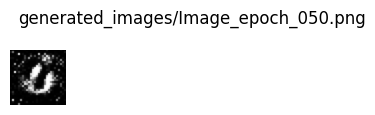

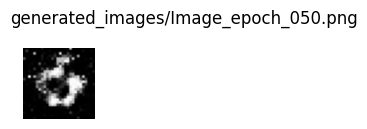

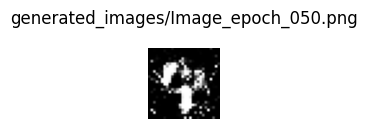

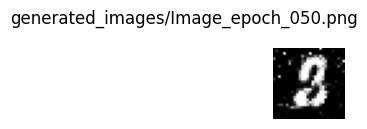

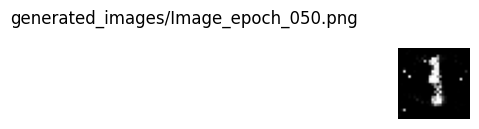

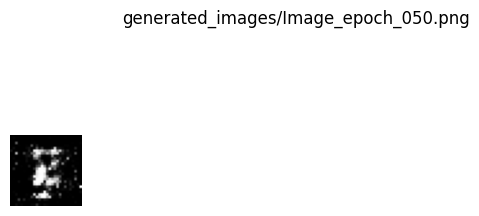

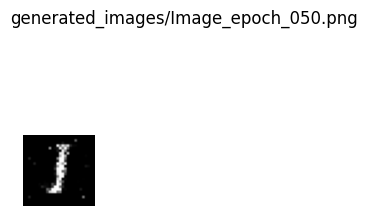

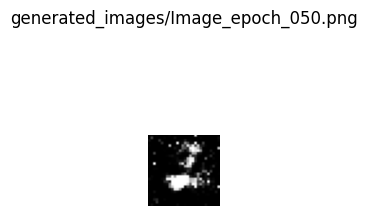

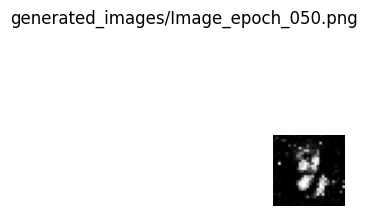

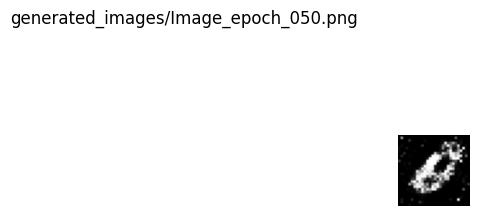

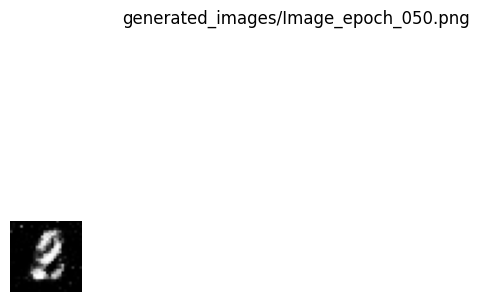

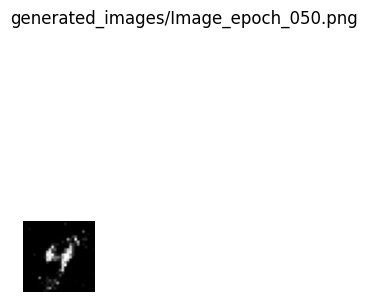

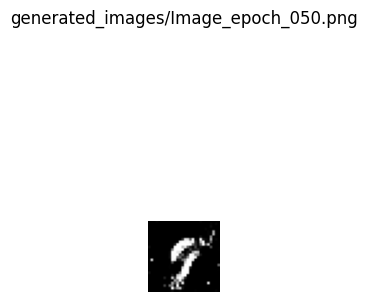

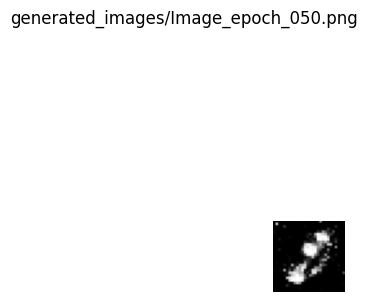

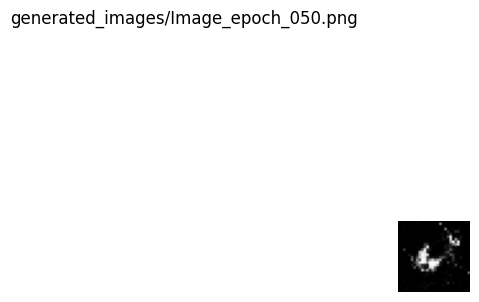

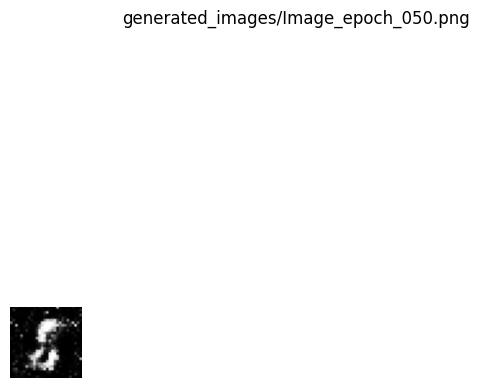

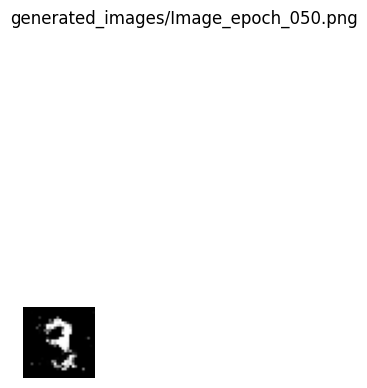

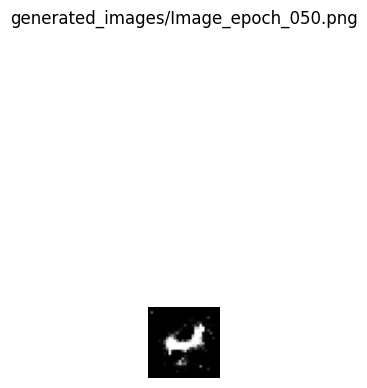

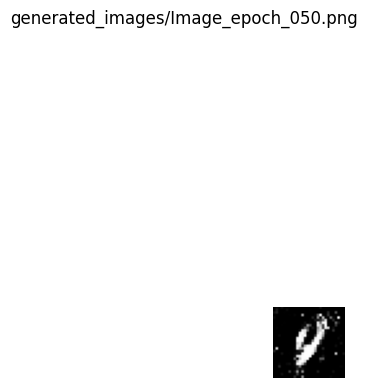

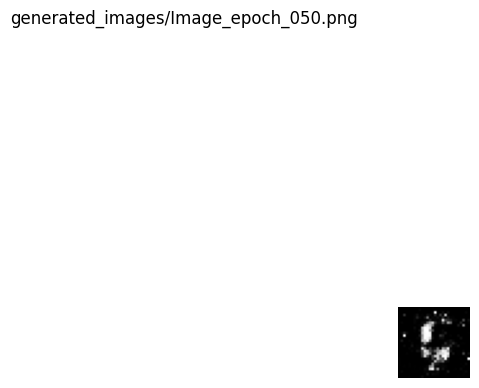

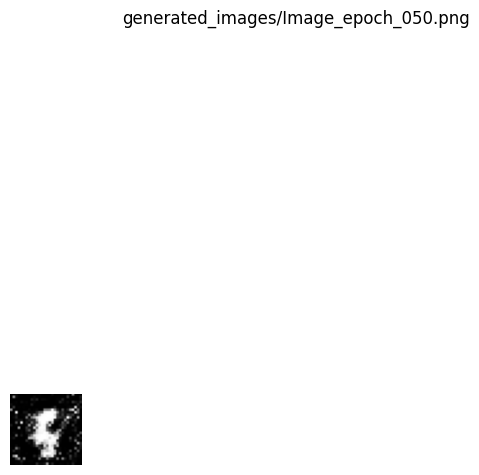

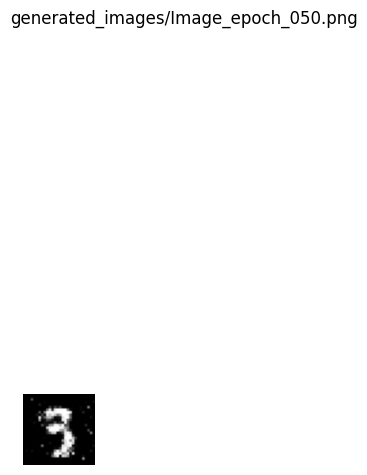

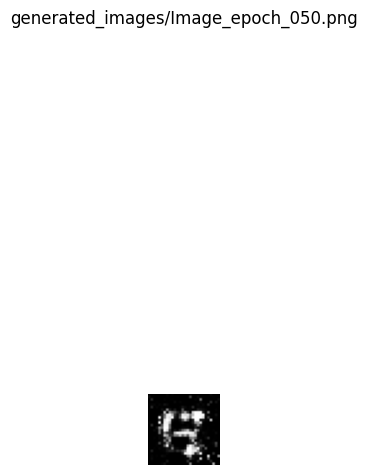

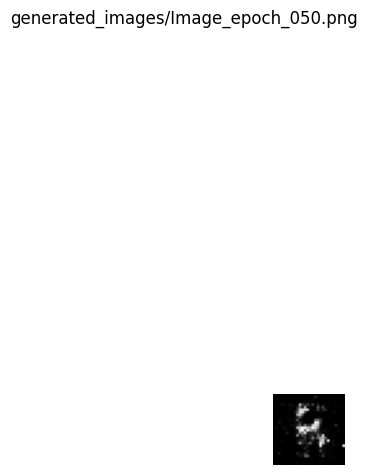

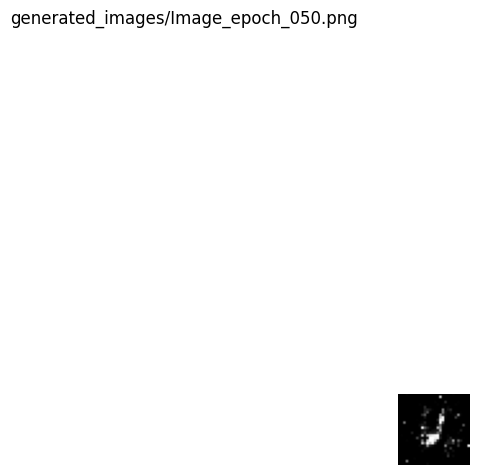

In [57]:
train(dataset,epochs=50)

In [58]:
def evaluate_discriminator():
  noise = tf.random.normal([btach_size,100])
  generated_images=generator(noise,training=False)
  real_images=next(iter(dataset))
  real_preds=discriminator(X_train,training=False)
  fake_preds=discriminator(generated_images,training=False)

  real acc =tf.reduce_mean(tf.cast(real_preds>0.5,tf.float32))
  fake_acc=tf.reduce_mean(tf.cast(real_preds>0.5,tf.float32))